In [1]:
import json
import joblib
import pickle
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/train_searched.csv")
df.head()

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
0,True,False,Bridgeport,10/01/2013 12:46:00 AM,Bridgeport,V,1207,True,I,Speed Related,37.0,H,W,M,True
1,True,True,Milford,10/01/2013 01:50:00 AM,MILFORD,E,2325,True,I,Defective Lights,30.0,N,W,M,True
2,True,False,Torrington,10/01/2013 03:49:00 AM,Torrington,V,DACYR048,True,C,Registration,43.0,N,W,M,True
3,True,False,State Police,10/01/2013 05:30:00 AM,TOLLAND,V,1000002715,False,C,Other,19.0,N,B,M,False
4,True,False,Greenwich,10/01/2013 05:47:00 AM,RIVERSIDE,V,110993,False,N,Speed Related,34.0,M,B,M,False


In [68]:
df.SubjectAge.isnull().sum()

0

In [3]:
# lowercaes departments and location names
df['Department Name'] = df['Department Name'].apply(lambda x: str(x).lower())
df['InterventionLocationName'] = df['InterventionLocationName'].apply(lambda x: str(x).lower())

In [4]:
train_features = df.columns.drop(['VehicleSearchedIndicator', 'ContrabandIndicator'])

In [5]:
categorical_features = train_features.drop(['InterventionDateTime', 'SubjectAge'])
numerical_features = ['SubjectAge']

In [6]:
target = 'ContrabandIndicator'

In [7]:
# show the most common feature values for all the categorical features
for feature in categorical_features:
    display(df[feature].value_counts())

state police                5449
new haven                   5006
wallingford                 2717
waterbury                   2506
west hartford               2214
                            ... 
mta stamford                   4
mta                            2
wcsu                           1
met dist water authority       1
ecsu                           1
Name: Department Name, Length: 117, dtype: int64

new haven               5719
waterbury               2938
wallingford             2771
norwich                 2201
bridgeport              2092
                        ... 
main street/ east el       1
coventry                   1
new haven                  1
high at turner             1
main street                1
Name: InterventionLocationName, Length: 458, dtype: int64

V    57944
E    13187
I     5612
Name: InterventionReasonCode, dtype: int64

1000003196    517
1000002072    370
790642042     349
10502         300
30233         299
             ... 
MLS0487         1
101278130       1
18907           1
345000640       1
100000408       1
Name: ReportingOfficerIdentificationID, Length: 4941, dtype: int64

True     70049
False     6694
Name: ResidentIndicator, dtype: int64

O    30670
C    27063
I    15710
N     3290
Name: SearchAuthorizationCode, dtype: int64

Other                     11066
Moving Violation           9969
Defective Lights           9127
Speed Related              8332
Registration               7329
Display of Plates          5859
Administrative Offense     4845
Stop Sign                  3738
Traffic Control Signal     3716
Window Tint                3375
Other/Error                2240
Seatbelt                   2173
Cell Phone                 1731
Suspended License          1376
Unlicensed Operation        697
STC Violation               595
Equipment Violation         562
Stop Sign                     3
Name: StatuteReason, dtype: int64

N    58343
H    17524
M      876
Name: SubjectEthnicityCode, dtype: int64

W    53524
B    22501
A      498
I      220
Name: SubjectRaceCode, dtype: int64

M    62686
F    14057
Name: SubjectSexCode, dtype: int64

False    46264
True     30479
Name: TownResidentIndicator, dtype: int64

In [8]:
# I'm going to remove less common features. 
# Let's create a dictionary with the minimum required number of appearences
min_frequency = {
    "Department Name": 50,
    "InterventionLocationName": 50,
    "ReportingOfficerIdentificationID": 30,
    "StatuteReason": 10
}

In [10]:
min_frequency.items()

dict_items([('Department Name', 50), ('InterventionLocationName', 50), ('ReportingOfficerIdentificationID', 30), ('StatuteReason', 10)])

In [15]:
value_counts = df["Department Name"].value_counts()
value_counts
to_keep = value_counts[value_counts > 50]
to_keep

state police     5449
new haven        5006
wallingford      2717
waterbury        2506
west hartford    2214
                 ... 
east lyme          89
scsu               74
shelton            71
granby             65
stonington         57
Name: Department Name, Length: 103, dtype: int64

In [16]:
def filter_values(df: pd.DataFrame, column_name: str, threshold: int):
    value_counts = df[column_name].value_counts()
    to_keep = value_counts[value_counts > threshold].index
    filtered = df[df[column_name].isin(to_keep)]
    return filtered

In [17]:
df.shape

(76743, 15)

In [18]:
for feature, threshold in min_frequency.items():
    df = filter_values(df, feature, threshold)

In [19]:
df.shape

(45334, 15)

In [23]:
X = df[train_features]
y = df[target]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [25]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features)])

pipeline = make_pipeline(
    preprocessor,
    LGBMClassifier(n_jobs=-1, random_state=42),
)

In [26]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Department Name', 'InterventionLocationName', 'InterventionReasonCode',
       'ReportingOfficerIdentificationID', 'ResidentIndicator',
       'SearchAuthorizationCode', 'StatuteReason', 'SubjectEthnicityCode',
       'SubjectRaceCode', 'SubjectSexCode', 'TownResidentIndicator'],
      dtype='object'))])),
                ('lgbmclassifier', LGBMClassifier(random_state=42))

In [35]:
preds = pipeline.predict(X_test)
preds_2= pipeline.predict_proba(X_test)
preds_2

array([[0.39236829, 0.60763171],
       [0.78677826, 0.21322174],
       [0.96591376, 0.03408624],
       ...,
       [0.74437072, 0.25562928],
       [0.94480763, 0.05519237],
       [0.66848456, 0.33151544]])

In [36]:
preds

array([ True, False, False, ..., False, False, False])

In [28]:
def verify_success_rate_above(y_true, y_pred, min_success_rate=0.5):
    """
    Verifies the success rate on a test set is above a provided minimum
    
    
    """
    
    precision = precision_score(y_true, y_pred, pos_label=True)
    is_satisfied = (precision >= min_success_rate)
    
    return is_satisfied, precision


In [29]:
def verify_amount_found(y_true, y_pred):
    """
    Verifies the amout of contraband found in the test dataset - a.k.a the recall in our test set
    """
    
    recall = recall_score(y_true, y_pred)    
    return recall


In [30]:
verify_success_rate_above(y_test, preds)

(True, 0.6681299385425812)

In [31]:
verify_amount_found(y_test, preds)

0.6125570163670513

Now let's find the best threshold for our requirements.

Precision needs to be at least 0.5, and recall has to be as max as possible.

It's usually true that the bigger is precision, the lower is the recall. 

So we need to find the threshold that coresponds to precision = 0.5

In [38]:
proba = pipeline.predict_proba(X_test)
proba

array([[0.39236829, 0.60763171],
       [0.78677826, 0.21322174],
       [0.96591376, 0.03408624],
       ...,
       [0.74437072, 0.25562928],
       [0.94480763, 0.05519237],
       [0.66848456, 0.33151544]])

In [39]:
y_test

45766    False
55808     True
59823    False
47880    False
34477     True
         ...  
70365     True
5520     False
71745    False
35879    False
34151    False
Name: ContrabandIndicator, Length: 11334, dtype: bool

In [41]:
precision, recall, thresholds = precision_recall_curve(y_test, proba[:, 1])

In [42]:
print(len(precision), len(recall), len(thresholds))

6615 6615 6614


In [43]:
precision

array([0.33585654, 0.33582695, 0.33585722, ..., 1.        , 1.        ,
       1.        ])

In [57]:
qq = ['a','s','f','v','n','h','g','d']
[el for el in enumerate(qq)]

[(0, 'a'),
 (1, 's'),
 (2, 'f'),
 (3, 'v'),
 (4, 'n'),
 (5, 'h'),
 (6, 'g'),
 (7, 'd')]

In [53]:
bb = [element for element in enumerate(precision) if element[1]>=0.5]
bb

[(2570, 0.5),
 (2571, 0.5000751089079165),
 (2572, 0.5001502403846154),
 (2573, 0.5002253944402705),
 (2574, 0.5001502855425308),
 (2575, 0.5002254621975049),
 (2576, 0.5001503307276007),
 (2577, 0.5003007518796992),
 (2578, 0.5003008423586041),
 (2579, 0.5003010234798314),
 (2580, 0.5002258015956647),
 (2581, 0.5003011141222523),
 (2582, 0.5003764493299202),
 (2583, 0.5004518072289157),
 (2584, 0.5005271878294923),
 (2585, 0.5006025911419102),
 (2586, 0.5006780171764351),
 (2587, 0.5007534659433394),
 (2588, 0.5008289374529012),
 (2589, 0.5007536930961712),
 (2590, 0.5008291873963516),
 (2591, 0.5009047044632087),
 (2592, 0.5009802443070427),
 (2593, 0.5010558069381599),
 (2594, 0.5009805400512898),
 (2595, 0.5009808359740455),
 (2596, 0.5011320754716981),
 (2597, 0.5010567632850241),
 (2598, 0.5011324173335346),
 (2599, 0.50120809423135),
 (2600, 0.5012837939888234),
 (2601, 0.5012841819005892),
 (2602, 0.5012088244182532),
 (2603, 0.5011334441589844),
 (2604, 0.5012091898428053),
 (

In [44]:
recall

array([1.00000000e+00, 9.99731688e-01, 9.99731688e-01, ...,
       5.36624631e-04, 2.68312316e-04, 0.00000000e+00])

In [46]:
thresholds

array([0.02332206, 0.0234002 , 0.02362547, ..., 0.9523625 , 0.95317882,
       0.95970433])

In [48]:
# according to documentation, precision and recall
# have 1 and 0 at the end, so we should remove them before plotting.
precision = precision[:-1]
recall = recall[:-1]
len(precision)

6613

In [49]:
ar = [1,2,3,4,5,6,7,8,9]
ar[:-1]

[1, 2, 3, 4, 5, 6, 7, 8]

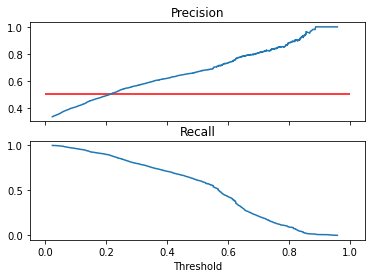

In [28]:
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.hlines(y=0.5,xmin=0, xmax=1, colors='red')
ax1.plot(thresholds,precision)
ax2.plot(thresholds,recall)
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
ax1.set_title('Precision')
ax2.set_title('Recall')
plt.xlabel('Threshold')
plt.show()

Red line shows the point where precision is equal 0.5. 

It looks like the biggest recall for precision >= 0.5 is around 0.2

Let's find the exact value.

In [50]:
enumerate(precision)

In [59]:
min_index = [i for i, prec in enumerate(precision) if prec >= 0.5][0]
print(min_index)

2570


In [60]:
precision[min_index]

0.5

In [61]:
recall[min_index]

0.8932116984169574

In [62]:
thresholds[min_index]

0.21073452797732833

In [63]:
best_preds = [1 if pred > thresholds[min_index] else 0 for pred in proba[:, 1]]

In [64]:
verify_success_rate_above(y_test, best_preds)

(True, 0.5000751089079165)

In [65]:
verify_amount_found(y_test, best_preds)

0.8932116984169574

In [66]:
with open('columns.json', 'w') as fh:
    json.dump(X_train.columns.tolist(), fh)
    
with open('dtypes.pickle', 'wb') as fh:
    pickle.dump(X_train.dtypes, fh)
    
joblib.dump(pipeline, 'pipeline.pickle');